In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
import math
import seaborn as sns
sns.set_theme(style="white", color_codes=True, font_scale=1.5)
sns.set_palette("Set2")
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.tri as tri
from matplotlib import cm
from matplotlib import rc
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=True)
from functools import reduce
from scipy import stats
from operator import mul
from collections import defaultdict
from itertools import cycle

from constrained.simplex.entropic import SimplexEntropicMap, safe_reciprocal
from constrained.simplex.proj import euclidean_proj_simplex
from constrained.sampling.svgd import svgd_update, proj_svgd_update
from constrained.sampling.svmd import svmd_update_v2
from constrained.sampling.kernel import imq, rbf
from constrained.target import Target
from utils import energy_dist

np.random.seed(123)
tf.random.set_seed(123)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
class DirichletTarget(Target):
    def __init__(self, alpha):
        self.alpha = tf.constant(alpha, dtype=tf.float64)
        super(DirichletTarget, self).__init__(SimplexEntropicMap())

    @tf.function
    def grad_logp(self, theta):
        return (self.alpha[:-1] - 1.) * safe_reciprocal(theta) - (self.alpha[-1] - 1.) * safe_reciprocal(
            1. - tf.reduce_sum(theta, axis=-1, keepdims=True))

    @tf.function
    def nabla_psi_inv_grad_logp(self, theta):
        # ret: [K, D - 1]
        return self.alpha[:-1] - 1. - tf.reduce_sum(self.alpha - 1.) * theta

    @tf.function
    def dual_grad_logp(self, eta, theta=None):
        return self.alpha[:-1] - tf.reduce_sum(self.alpha) * theta

In [3]:
class PlotSimplex:
    def __init__(self, corners):
        self._corners = corners
        self._triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
        # Midpoints of triangle sides opposite of each corner
        self._midpoints = [(corners[(i+1) % 3] + corners[(i+2) % 3]) / 2.0 for i in range(3)]
        
    def xy2bc(self, xy, tol=1.e-16):
        s = [(self._corners[i] - self._midpoints[i]).dot(xy - self._midpoints[i]) / 0.75 for i in range(3)]
        return s

    def draw_pdf_contours(self, ax, target, label=None, nlevels=100, subdiv=5, **kwargs):
        """Draw pdf contours for a Dirichlet distribution"""
        # Subdivide the triangle into a triangular mesh
        refiner = tri.UniformTriRefiner(self._triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        triangles = trimesh.triangles
        xys = [(trimesh.x[tri].mean(), trimesh.y[tri].mean()) for tri in triangles]
        
        # convert to barycentric coordinates and compute probabilities of the given distribution 
        pvals = [tf.exp(target.logp(np.array(self.xy2bc(xy))[None, :2])).numpy().squeeze(0) for xy in xys]

        # YlGnBu
        tcf = ax.tripcolor(trimesh, pvals, cmap="YlGnBu", antialiased=False, edgecolors="face")
        ax.axis('equal')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.75**0.5)
        if label is not None:
            ax.set_title(
                np.array2string(np.array(label), separator=", ", suppress_small=True, precision=2)[1:-1],
                fontsize=18
            )
        ax.axis('off')
        plt.colorbar(tcf, ax=ax, fraction=0.046, pad=0.04)
        # ax.triplot(self._triangle, linewidth=1.5, color="k")
        return ax
    
    def plot_points(self, ax, X, barycentric=True, border=True, **kwargs):
        '''Plots a set of points in the simplex.
        Arguments:
            `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                           (if in barycentric coords) of points to plot.
            `barycentric` (bool): Indicates if `X` is in barycentric coords.
            `border` (bool): If True, the simplex border is drawn.
            kwargs: Keyword args passed on to `plt.plot`.
        '''
        if barycentric is True:
            X = X.dot(self._corners)
        ax.scatter(X[:, 0], X[:, 1], **kwargs)
        ax.axis('equal')
        ax.set_xlim(0 - 0.1, 1 + 0.1)
        ax.set_ylim(0 - 0.1, 0.75**0.5 + 0.1)
        ax.axis('off')
        if border is True:
            ax.triplot(self._triangle, linewidth=1, c="k")

In [4]:
K = 50
D = 20
alpha = np.ones(D, dtype=np.float64) * 0.1
# alpha = np.ones(D, dtype=np.float64) * 2
alpha[:3] += np.array([90., 5., 5.])

target = DirichletTarget(alpha)

In [5]:
if D == 3:
    f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    plot_simplex = PlotSimplex(corners)
    plot_simplex.draw_pdf_contours(ax, target)

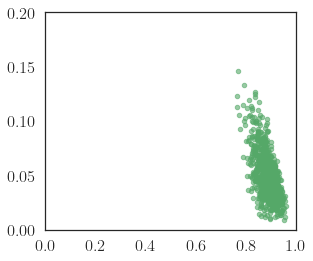

In [6]:
ground_truth_set = np.random.dirichlet(alpha, size=1000).astype(np.float64)
ground_truth_set = tf.constant(ground_truth_set[:, :-1], dtype=tf.float64)
if D == 3:
    f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
    plot_simplex.plot_points(ax, ground_truth_set.numpy(), alpha=.6, c="g", s=20)
else:
    f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
    ground_truth_set_np = ground_truth_set.numpy()[:, :2]
    ax.scatter(ground_truth_set_np[:, 0], ground_truth_set_np[:, 1], alpha=.6, c="g", s=20)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 0.2])

In [7]:
def run(target, ground_truth_set, method="smvd", lr=0.005):
    q0 = tfp.distributions.Dirichlet(tf.ones(D, dtype=tf.float64)*5)
    theta_full = q0.sample(K)
    # theta: [K, D - 1]
    theta0 = theta_full[:, :-1]
    if method == "proj_svgd":
        theta = tf.Variable(theta0)
    else:
        theta = theta0
        eta0 = target.mirror_map.nabla_psi(theta)
        # eta: [K, D - 1]
        eta = tf.Variable(eta0)
    n_iters = 500
    kernel = imq
    eds = []
    trange = tqdm(range(n_iters))
    optimizer = tf.keras.optimizers.RMSprop(lr)
#     optimizer = tf.keras.optimizers.SGD(lr)
    for t in trange:
        if method == "svmd":
            eta_grad = svmd_update_v2(target, theta, kernel, n_eigen_threshold=0.98)
        elif method == "svgd":
            eta_grad = svgd_update(target, eta, theta, kernel)
        elif method == "proj_svgd":
            theta_grad = proj_svgd_update(target, theta, kernel)
        else:
            raise NotImplementedError()

        if method == "proj_svgd":
            optimizer.apply_gradients([(-theta_grad, theta)])
            theta_ext = tf.concat([theta, 1 - tf.reduce_sum(theta, axis=-1, keepdims=True)], -1)
            theta.assign(euclidean_proj_simplex(theta_ext)[..., :-1])
        else:
            optimizer.apply_gradients([(-eta_grad, eta)])
            theta = target.mirror_map.nabla_psi_star(eta)
        if t % 20 == 0:
            ed = energy_dist(ground_truth_set, theta)
            eds.append(ed.numpy())
    theta_ext = tf.concat([theta, 1 - tf.reduce_sum(theta, axis=-1, keepdims=True)], -1)
    return theta_ext, eds

In [8]:
methods = ["svmd", "svgd", "proj_svgd"]

In [9]:
# search_lr = [0.1, 0.01, 0.001]
samples_dict = defaultdict(list)
eds_dict = defaultdict(list)

lr_map = {
    "svgd": 0.1,
    "svmd": 0.1,
    "proj_svgd": 1e-4,
}

for method in methods:
    theta, eds = run(target, ground_truth_set, method=method, lr=lr_map[method])
    eds_dict[method].append(eds)
    samples_dict[method].append(theta)

100%|██████████| 500/500 [00:03<00:00, 166.37it/s]


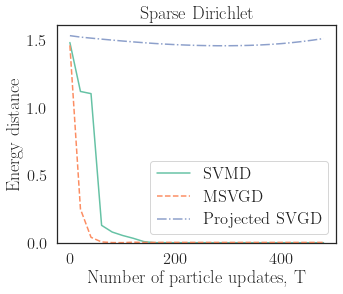

In [10]:
f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_title("Sparse Dirichlet")
name_map = {
    "svgd": "MSVGD",
    "svmd": "SVMD",
    "proj_svgd": "Projected SVGD"
}
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for i, method in enumerate(methods):
    linestyle = next(linecycler)
    # for j, lr in enumerate(search_lr):
    #     if lr in [0.1, 0.01]: 
    ax.plot(np.arange(len(eds_dict[method][0])) * 20, eds_dict[method][0], linestyle, label="{}".format(name_map[method]))
ax.set_ylim(bottom=0)
ax.set_xlabel("Number of particle updates, T")
ax.set_ylabel("Energy distance")
ax.legend()
plt.savefig("dirichlet_{}d.pdf".format(D), bbox_inches="tight", dpi=150)

In [11]:
search_lr = [0.1, 0.01, 0.001]
samples_dict = defaultdict(list)
eds_dict = defaultdict(list)

for method in methods:
    if method == "proj_svgd":
        search_lr = [0.01, 0.001, 1e-4]
    for lr in search_lr:
        theta, eds = run(target, ground_truth_set, method=method, lr=lr)
        eds_dict[method].append(eds)
        samples_dict[method].append(theta)

100%|██████████| 500/500 [00:02<00:00, 188.70it/s]


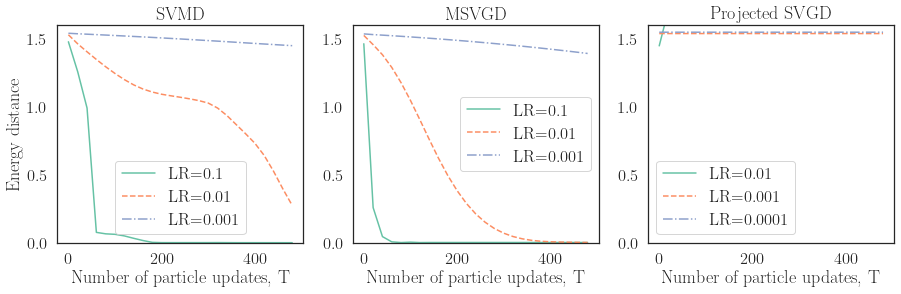

In [15]:
f, axes = plt.subplots(1, len(methods), figsize=(5 * len(methods), 4))

for i, method in enumerate(methods):
    if method == "proj_svgd":
        search_lr_ = [0.01, 0.001, 1e-4]
    else:
        search_lr_ = [0.1, 0.01, 0.001]
    linecycler = cycle(lines)
    for j, lr in enumerate(search_lr_):
        linestyle = next(linecycler)
        axes[i].plot(np.arange(len(eds_dict[method][0])) * 20, eds_dict[method][j], linestyle, label="LR={}".format(lr))
    axes[i].set_title(name_map[method])
    axes[i].set_ylim(top=1.6, bottom=0)
    axes[i].set_xlabel("Number of particle updates, T")
    if i == 0:
        axes[i].set_ylabel("Energy distance")
    axes[i].legend()
plt.savefig("dir_{}d_wrt_lr.pdf".format(D), bbox_inches="tight", dpi=150)

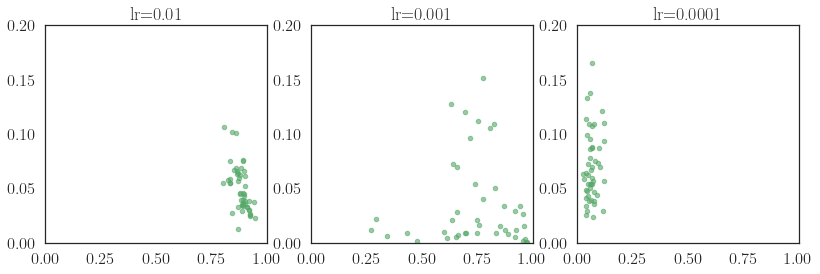

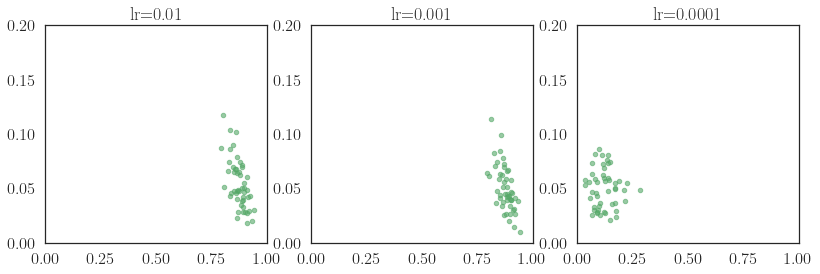

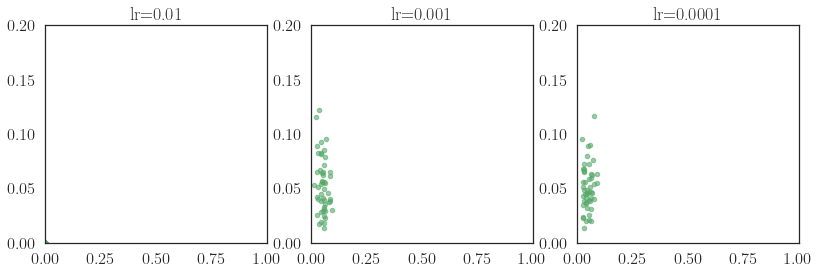

In [13]:
for method in methods:
    f, axes = plt.subplots(1, len(search_lr), figsize=(4.5 * len(search_lr), 4))
    for i, samples in enumerate(samples_dict[method]):
        if D == 3:
    #         f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
            plot_simplex.plot_points(axes[i], samples.numpy(), alpha=.6, c="g", s=20)
        else:
    #         f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
            samples_np = samples.numpy()
            axes[i].scatter(samples_np[:, 0], samples_np[:, 1], alpha=.6, c="g", s=20)
            axes[i].set_xlim([0, 1])
            axes[i].set_ylim([0, 0.2])
            axes[i].set_title("lr={}".format(search_lr[i]))